# Common

## Imports and Helper Function

In [11]:
# imports
import numpy as np
import math
np.random.seed(42)

# # helper function
# def print_matop(*matrices, separator="\t\t"):
#     # Find the maximum number of rows across all matrices
#     max_rows = max(len(matrix) for matrix in matrices)
    
#     # Iterate over the rows by index up to the max number of rows
#     for i in range(max_rows):
#         formatted_rows = []
#         for matrix in matrices:
#             # Check if the matrix has a row at index i
#             if i < len(matrix):
#                 row = matrix[i]
#                 # If row is iterable (like a list or numpy array), format each element
#                 if hasattr(row, '__iter__'):
#                     formatted_rows.append("[" + " ".join(f"{val:2.2f}" for val in row) + "]")
#                 else:
#                     # If it's a single scalar value, format it directly
#                     formatted_rows.append(f"{row:2.2f}")
#             else:
#                 # Add an empty value if the matrix does not have enough rows
#                 formatted_rows.append('\t')
        
#         # Join the formatted rows with the specified separator and print them
#         print(separator.join(formatted_rows))

def print_matop(*matrices, separator="\t\t", width=5):
    """
    Prints multiple matrices side by side, ensuring proper alignment.
    
    Args:
    - matrices: The matrices to print side by side.
    - separator: The string used to separate the matrices in the output.
    - width: The fixed width for each element in the matrix to ensure alignment.
    """
    # Find the maximum number of rows across all matrices
    max_rows = max(len(matrix) for matrix in matrices)
    
    # Iterate over the rows by index up to the max number of rows
    for i in range(max_rows):
        formatted_rows = []
        for matrix in matrices:
            # Check if the matrix has a row at index i
            if i < len(matrix):
                row = matrix[i]
                # If row is iterable (like a list or numpy array), format each element
                if hasattr(row, '__iter__'):
                    formatted_rows.append("[" + " ".join(f"{val:{width}.2f}" for val in row) + "]")
                else:
                    # If it's a single scalar value, format it directly
                    formatted_rows.append(f"  {row:{width}.2f}")
            else:
                # Add an empty value if the matrix does not have enough rows
                formatted_rows.append('\t' * (width // 4))
        
        # Join the formatted rows with the specified separator and print them
        print(separator.join(formatted_rows))

## Sample Input

In [2]:
# SRAM memory size
M = 20
# simplified head size = hidden size
d = 2
# Sequence length
N = 6

# set block size for outer loop
Bc = math.ceil(M / (4 * d))
print(f"Bc: {Bc}")
# set block size for inner loop
Br = min(Bc, d)
print(f"Br: {Br}")

# Example dimensions for Q, K, V matrices
Q = np.random.randn(N, d)
K = np.random.randn(N, d)
V = np.random.randn(N, d)
print(f"\tQ \t\t\t K \t\t\t V")
print_matop(Q, K, V)
O = np.zeros((N, d))

dO = np.random.randn(N, d)  # Assume dO comes from the next layer
print(f"the dO obtained from next layer backprop (assumed):")
print_matop(dO)

tau = 1 / np.sqrt(d)
p_drop = 0.1

Bc: 3
Br: 2
	Q 			 K 			 V
[0.50 -0.14]		[0.24 -1.91]		[-0.54 0.11]
[0.65 1.52]		[-1.72 -0.56]		[-1.15 0.38]
[-0.23 -0.23]		[-1.01 0.31]		[-0.60 -0.29]
[1.58 0.77]		[-0.91 -1.41]		[-0.60 1.85]
[-0.47 0.54]		[1.47 -0.23]		[-0.01 -1.06]
[-0.46 -0.47]		[0.07 -1.42]		[0.82 -1.22]
the dO obtained from next layer backprop (assumed):
[0.21 -1.96]
[-1.33 0.20]
[0.74 0.17]
[-0.12 -0.30]
[-1.48 -0.72]
[-0.46 1.06]


In [3]:
import numpy as np
from scipy.special import softmax  # Optional, can use numpy's method or scipy's

def attention(Q, K, V):
    # Step 1: Calculate the dot product of Q and K.T (scores)
    S = np.dot(Q, K.T)  # (N, d) @ (d, N) -> (N, N)
    
    # Step 2: Apply the softmax to the scores for each row
    P = softmax(S, axis=1)  # Softmax along the rows
    
    # Step 3: Multiply the attention weights with the value matrix V
    O = np.dot(P, V)  # (N, N) @ (N, d) -> (N, d)
    
    return O

# Calculate the attention output
_O = attention(Q, K, V)

# Print the result
print("Attention Output O:")
with np.printoptions(precision=2, suppress=True):
    print(_O)


Attention Output O:
[[-0.17 -0.33]
 [-0.22 -0.7 ]
 [-0.41  0.14]
 [-0.03 -0.97]
 [-0.6   0.07]
 [-0.47  0.29]]


# Flash Attention 1

## Simplified Forward Pass 
### Algorithm

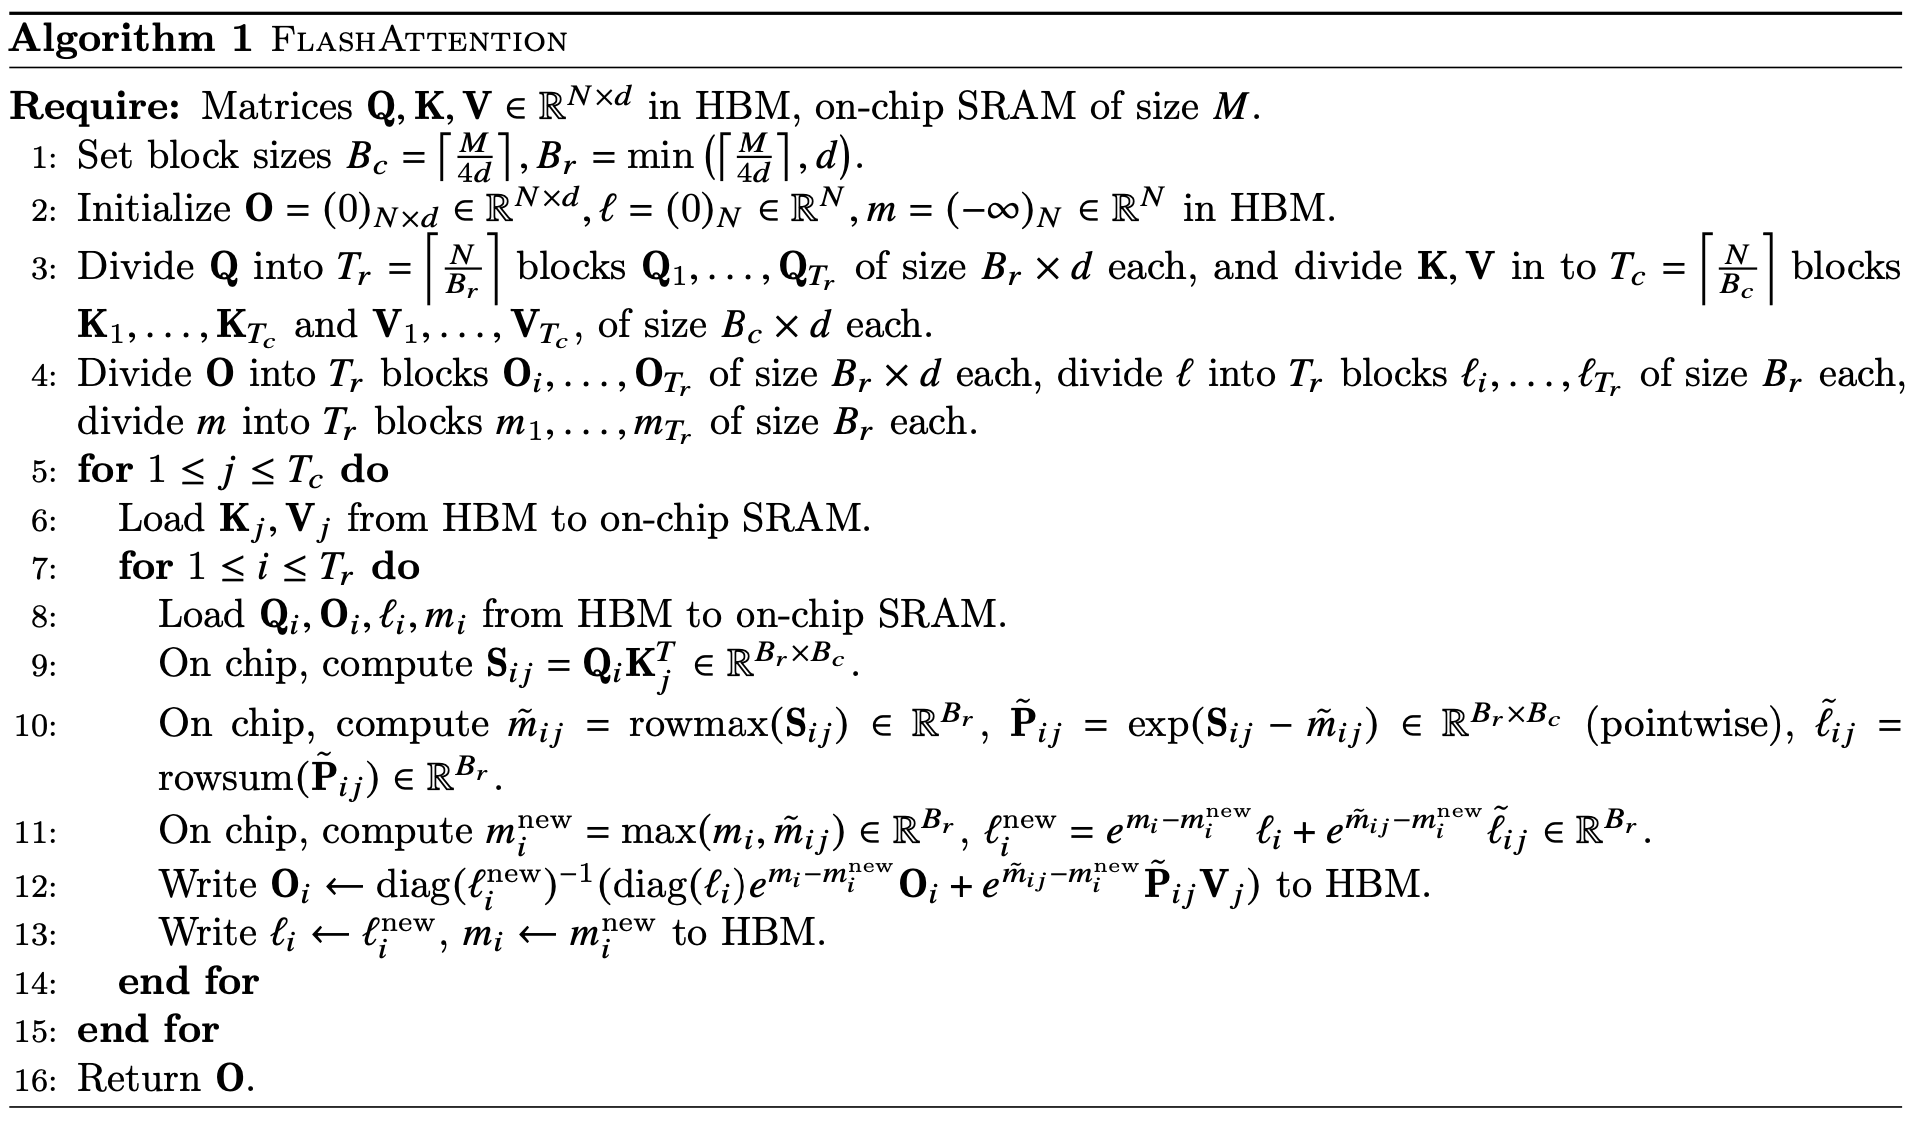

### Initialization

In [4]:
# Initialize output and intermediate arrays in HBM (using numpy arrays as example)
O = np.zeros((N, d))
l = np.zeros((N,1))
m = -np.inf * np.ones((N,1))
with np.printoptions(precision=2, suppress=True):
    print(f"O \t\t l \t m")
    for ro, rl, rm in zip(O, l, m):
        print(f"{ro} \t {rl} \t {rm}")

O 		 l 	 m
[0. 0.] 	 [0.] 	 [-inf]
[0. 0.] 	 [0.] 	 [-inf]
[0. 0.] 	 [0.] 	 [-inf]
[0. 0.] 	 [0.] 	 [-inf]
[0. 0.] 	 [0.] 	 [-inf]
[0. 0.] 	 [0.] 	 [-inf]


In [5]:
# Divide Q into Tr blocks of size Br x d
Tr = math.ceil(N / Br)
print(f"Tr:{Tr} = ceil(N:{N} / Br:{Br})")
Q_blocks = [Q[i:i + Br] for i in range(0, len(Q), Br)]
with np.printoptions(precision=2, suppress=True):
    print("Q_blocks:")
    for i, block in enumerate(Q_blocks):
        print(f"{i+1}th")
        print(block)

Tr:3 = ceil(N:6 / Br:2)
Q_blocks:
1th
[[ 0.5  -0.14]
 [ 0.65  1.52]]
2th
[[-0.23 -0.23]
 [ 1.58  0.77]]
3th
[[-0.47  0.54]
 [-0.46 -0.47]]


In [6]:
# Divide K, V into Tc blocks of size Bc x d
Tc = math.ceil(N / Bc)
print(f"Tc:{Tc} = ceil(N:{N} / Bc:{Bc})")

K_blocks = [K[i:i + Bc] for i in range(0, len(K), Bc)]
V_blocks = [V[i:i + Bc] for i in range(0, len(V), Bc)]
with np.printoptions(precision=2, suppress=True):
    print(f"K_block \t\t V_block")
    for i, _ in enumerate(K_blocks):
        print(f"{i+1}th")
        print_matop(K_blocks[i], V_blocks[i])

hbm = {
    'K_blocks': K_blocks,
    'V_blocks': V_blocks,
    'Q_blocks': Q_blocks,
    'O': O,
    'l': l,
    'm': m
}

Tc:2 = ceil(N:6 / Bc:3)
K_block 		 V_block
1th
[0.24 -1.91]		[-0.54 0.11]
[-1.72 -0.56]		[-1.15 0.38]
[-1.01 0.31]		[-0.60 -0.29]
2th
[-0.91 -1.41]		[-0.60 1.85]
[1.47 -0.23]		[-0.01 -1.06]
[0.07 -1.42]		[0.82 -1.22]


### Function

In [7]:
def inner_iter(i, j, hbm=hbm):
    K_blocks = hbm['K_blocks']
    V_blocks = hbm['V_blocks']
    Q_blocks = hbm['Q_blocks']
    O = hbm['O']
    m = hbm['m']
    l = hbm['l']

    with np.printoptions(precision=2, suppress=True):

        # Loop over K, V blocks (outer loop)
        Kj = K_blocks[j-1]
        Vj = V_blocks[j-1]
        # Loop over Q blocks (inner loop)
        Qi = Q_blocks[i-1]
        print()
        print('#' * 50)
        print(f"Processing blocks K{j} V{j} Q{i}")
        # print(f"K{j}(Bc, d) \t V{j}(Bc, d) \t Q{i}(Br, d)")
        # print_matop(Kj, Vj, Qi, separator='\t')

        # Compute Sij = Q_i * K_j^T
        Sij = Qi @ Kj.T
        print(f"local self attention dot-product:")
        print(f"S{i}{j}(Br, Bc) \t=\t Q{i}(Br, d) @\t K{j}^T (d, Bc):")
        print_matop(Sij, Qi, Kj.T, separator='\t')

        # Compute mij and exp(Sij - mij)
        mij = np.max(Sij, axis=1, keepdims=True)
        Sij_ = Sij - mij
        Pij = np.exp(Sij_)
        lij = np.sum(Pij, axis=1, keepdims=True)

        print(f"local row-wise max:")
        print(f"m{i}{j}(Br, 1) \t<=rowmax\t S{i}{j}(Br, Bc):")
        print_matop(mij, Sij, separator='\t\t\t\t')
        print(f"local softmax denominator:")
        print(f"l{i}{j}(Br, 1) \t<=rowsum\t P{i}{j}(Br, Bc) \t\t<=exp\t\t\t (S{i}{j} - m{i}{j}):")
        print_matop(lij, Pij, Sij_, separator='\t\t\t\t')

        Oi = O[(i-1)*Br:i*Br] # (Br, d)
        mi = m[(i-1)*Br:i*Br] # (Br, 1)
        li = l[(i-1)*Br:i*Br]  # (Br, 1)
        print(f'from HBM read in cumulative Output, Row_max and Softmax_denominator:')
        print(f'O{i} \t\t\t m{i} \t\t l{i}')
        print_matop(Oi, mi, li, separator='\t\t')

        # Update m_i_, l_i_
        mi_ = np.maximum(mi, mij)
        print(f"updated cumulative max:")
        print(f"m{i}_(Br,1) \t=\t max(m{i} \t,\t m{i}{j})")
        print_matop(mi_, mi, mij, separator='\t\t\t')

        past_scaled_l = np.exp(mi - mi_) * li
        local_l = np.exp(mij-mi_) * lij
        li_ = past_scaled_l + local_l
        print(f"updated cumulative softmax denominator:")
        print(f"l{i}_(Br,1) \t=\t exp(m{i}-m{i}_) \t*\t l{i} \t\t+\t exp(m{i}{j}-m{i}_) \t*\t l{i}{j}")
        print_matop(li_, np.exp(mi - mi_), li, np.exp(mij-mi_), lij, separator='\t\t\t')

        # Update O_i
        inv_li_ = np.diag(1.0 / li_.flatten())
        scaled_Oi = np.diag(li.flatten()) @ (np.exp(mi-mi_) * Oi)
        print(f"scaled cumulative Output of previous blocks, i.e. [from Q0 to Q{i-1}] @ K{j}.T @ V{j}")
        print(f"scaled_O{i} \t=\t diag(l{i}) \t@\t [exp(m{i}-m{i}_) \t*\t O{i}] \t=\t diag(l{i}) \t@\t [exp(m{i}-m{i}_)*O{i}]")
        print_matop(scaled_Oi, np.diag(li.flatten()), np.exp(mi-mi_), Oi, np.diag(li.flatten()), np.exp(mi-mi_)*Oi)

        scaled_PV = np.exp(mij - mi_) * Pij @ Vj
        print(f"scaled local P@V of current block")
        print(f"scaled_PV \t=\t exp(m{i}{j}-m{i}_) \t*\t [P{i}{j} \t\t@\t V{j}] \t=\t exp(m{i}{j}-m{i}_) \t*\t PV")
        print_matop(scaled_PV, np.exp(mij - mi_), Pij, Vj, np.exp(mij - mi_), Pij@Vj, separator='\t\t')

        Oi = inv_li_ @ (scaled_Oi + scaled_PV)
        print(f"updated cumulative Output of all blocks, i.e. [from Q0 to Q{i}] @ K{j}.T @ V{j}")
        print(f"O{i}_ (Br,d) \t=\t inv_l{i}_\t@\t (scaled_O{i}\t+\t scaled_PV)")
        print_matop(Oi, inv_li_, scaled_Oi, scaled_PV, separator='\t\t')

        # write out Oi to HBM
        hbm['O'][(i-1)*Br:i*Br] = Oi
        # write out li and mi to HBM
        hbm['l'][(i-1)*Br:i*Br] = li_
        hbm['m'][(i-1)*Br:i*Br] = mi_
        print(f'after saving O{i}, m{i}, l{i} to HBM')
        print(f"O \t\t\t m \t\t\t l ")
        print_matop(hbm['O'], hbm['m'], hbm['l'], separator='\t\t')

    return hbm


### Iterations

In [8]:
for j in range(1, len(K_blocks)+1, 1):
    for i in range(1, len(Q_blocks)+1, 1):
        hbm = inner_iter(i, j, hbm=hbm)


##################################################
Processing blocks K1 V1 Q1
local self attention dot-product:
S11(Br, Bc) 	=	 Q1(Br, d) @	 K1^T (d, Bc):
[0.38 -0.78 -0.55]	[0.50 -0.14]	[0.24 -1.72 -1.01]
[-2.76 -1.97 -0.18]	[0.65 1.52]	[-1.91 -0.56 0.31]
local row-wise max:
m11(Br, 1) 	<=rowmax	 S11(Br, Bc):
[0.38]				[0.38 -0.78 -0.55]
[-0.18]				[-2.76 -1.97 -0.18]
local softmax denominator:
l11(Br, 1) 	<=rowsum	 P11(Br, Bc) 		<=exp			 (S11 - m11):
[1.71]				[1.00 0.31 0.39]				[0.00 -1.16 -0.93]
[1.24]				[0.08 0.17 1.00]				[-2.58 -1.80 0.00]
from HBM read in cumulative Output, Row_max and Softmax_denominator:
O1 			 m1 		 l1
[0.00 0.00]		[-inf]		[0.00]
[0.00 0.00]		[-inf]		[0.00]
updated cumulative max:
m1_(Br,1) 	=	 max(m1 	,	 m11)
[0.38]			[-inf]			[0.38]
[-0.18]			[-inf]			[-0.18]
updated cumulative softmax denominator:
l1_(Br,1) 	=	 exp(m1-m1_) 	*	 l1 		+	 exp(m11-m1_) 	*	 l11
[1.71]			[0.00]			[0.00]			[1.00]			[1.71]
[1.24]			[0.00]			[0.00]			[1.00]			[1.24]
scaled cumul

## Full Detail Forward Pass

### Algorithm

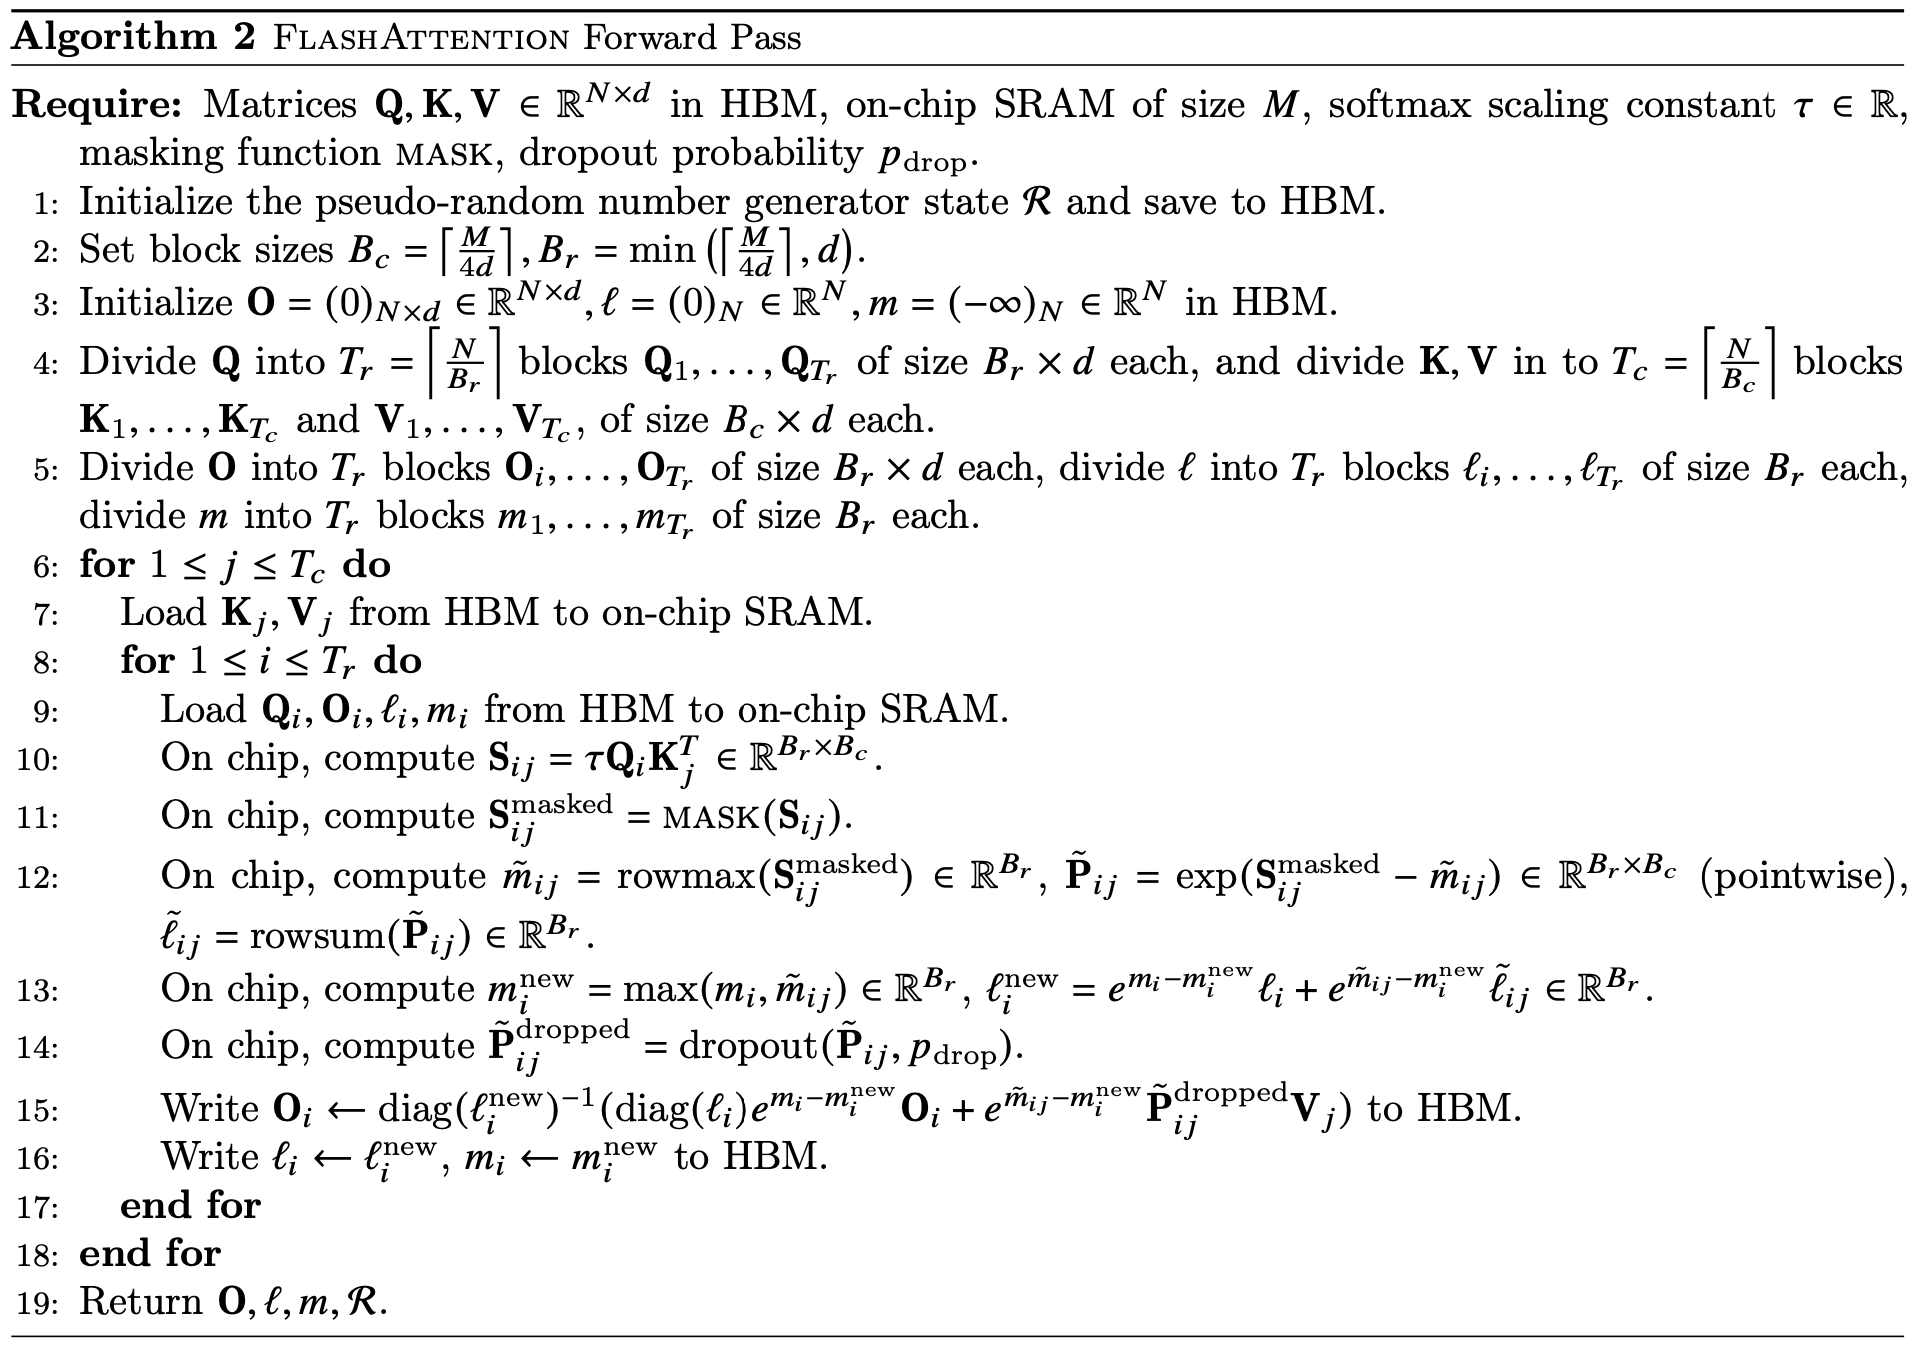

### Function

In [9]:
def inner_iter(i, j, hbm=hbm):
    K_blocks = hbm['K_blocks']
    V_blocks = hbm['V_blocks']
    Q_blocks = hbm['Q_blocks']
    O = hbm['O']
    m = hbm['m']
    l = hbm['l']

    with np.printoptions(precision=2, suppress=True):

        # Loop over K, V blocks (outer loop)
        Kj = K_blocks[j-1]
        Vj = V_blocks[j-1]
        # Loop over Q blocks (inner loop)
        Qi = Q_blocks[i-1]
        print()
        print('#' * 50)
        print(f"Processing blocks K{j} V{j} Q{i}")
        # print(f"K{j}(Bc, d) \t V{j}(Bc, d) \t Q{i}(Br, d)")
        # print_matop(Kj, Vj, Qi, separator='\t')

        # Compute Sij = Q_i * K_j^T
        Sij = tau * Qi @ Kj.T
        print(f"local self attention dot-product:")
        print(f"S{i}{j}(Br, Bc) \t=\t Q{i}(Br, d) @\t K{j}^T (d, Bc):")
        print_matop(Sij, Qi, Kj.T, separator='\t')

        # Apply causal mask directly to Sij
        Sij = np.where(np.tril(np.ones_like(Sij), k=0) == 1, Sij, -np.inf)
        print(f"masked S{i}{j}")
        print(Sij)

        # Compute mij and exp(Sij - mij)
        mij = np.max(Sij, axis=1, keepdims=True)
        Sij_ = Sij - mij
        
        print(f"local row-wise max:")
        print(f"m{i}{j}(Br, 1) \t<=rowmax\t S{i}{j}(Br, Bc):")
        print_matop(mij, Sij, separator='\t\t\t\t')

        # Apply dropout to Pij
        Pij = np.exp(Sij_)
        drop_mask = np.random.rand(*Pij.shape) > p_drop
        Pij_ = Pij * (drop_mask / (1 - p_drop))
        print(f"local drop_out masked P{i}{j}:")
        print(f"P{i}{j}_(Br, Bc) \t<=drop_out\t P{i}{j}(Br, Bc) \t\t<=exp\t (S{i}{j} - m{i}{j}):")
        print_matop(Pij_, Pij, Sij_, separator='\t\t')

        lij = np.sum(Pij_, axis=1, keepdims=True)
        print(f"local softmax denominator:")
        print(f"l{i}{j}(Br, 1) \t<=rowsum\t P{i}{j}_(Br, Bc):")
        print_matop(lij, Pij_, separator='\t\t\t\t')

        Oi = O[(i-1)*Br:i*Br] # (Br, d)
        mi = m[(i-1)*Br:i*Br] # (Br, 1)
        li = l[(i-1)*Br:i*Br]  # (Br, 1)
        print(f'from HBM read in cumulative Output, Row_max and Softmax_denominator:')
        print(f'O{i} \t\t\t m{i} \t\t l{i}')
        print_matop(Oi, mi, li, separator='\t\t')

        # Update m_i_, l_i_
        mi_ = np.maximum(mi, mij)
        print(f"updated cumulative max:")
        print(f"m{i}_(Br,1) \t=\t max(m{i} \t,\t m{i}{j})")
        print_matop(mi_, mi, mij, separator='\t\t\t')

        past_scaled_l = np.exp(mi - mi_) * li
        local_l = np.exp(mij-mi_) * lij
        li_ = past_scaled_l + local_l
        print(f"updated cumulative softmax denominator:")
        print(f"l{i}_(Br,1) \t=\t exp(m{i}-m{i}_) \t*\t l{i} \t\t+\t exp(m{i}{j}-m{i}_) \t*\t l{i}{j}")
        print_matop(li_, np.exp(mi - mi_), li, np.exp(mij-mi_), lij, separator='\t\t\t')

        # Update O_i
        inv_li_ = np.diag(1.0 / li_.flatten())
        scaled_Oi = np.diag(li.flatten()) @ (np.exp(mi-mi_) * Oi)
        print(f"scaled cumulative Output of previous blocks, i.e. [from Q0 to Q{i-1}] @ K{j}.T @ V{j}")
        print(f"scaled_O{i} \t=\t diag(l{i}) \t@\t [exp(m{i}-m{i}_) \t*\t O{i}] \t=\t diag(l{i}) \t@\t [exp(m{i}-m{i}_)*O{i}]")
        print_matop(scaled_Oi, np.diag(li.flatten()), np.exp(mi-mi_), Oi, np.diag(li.flatten()), np.exp(mi-mi_)*Oi)

        scaled_PV = np.exp(mij - mi_) * Pij @ Vj
        print(f"scaled local P@V of current block")
        print(f"scaled_PV \t=\t exp(m{i}{j}-m{i}_) \t*\t [P{i}{j} \t\t@\t V{j}] \t=\t exp(m{i}{j}-m{i}_) \t*\t PV")
        print_matop(scaled_PV, np.exp(mij - mi_), Pij, Vj, np.exp(mij - mi_), Pij@Vj, separator='\t\t')

        Oi = inv_li_ @ (scaled_Oi + scaled_PV)
        print(f"updated cumulative Output of all blocks, i.e. [from Q0 to Q{i}] @ K{j}.T @ V{j}")
        print(f"O{i}_ (Br,d) \t=\t inv_l{i}_\t@\t (scaled_O{i}\t+\t scaled_PV)")
        print_matop(Oi, inv_li_, scaled_Oi, scaled_PV, separator='\t\t')

        # write out Oi to HBM
        hbm['O'][(i-1)*Br:i*Br] = Oi
        # write out li and mi to HBM
        hbm['l'][(i-1)*Br:i*Br] = li_
        hbm['m'][(i-1)*Br:i*Br] = mi_
        print(f'after saving O{i}, m{i}, l{i} to HBM')
        print(f"O \t\t\t m \t\t l ")
        print_matop(hbm['O'], hbm['m'], hbm['l'], separator='\t\t')

    return hbm

### Iterations

In [10]:
for j in range(1, len(K_blocks)+1, 1):
    for i in range(1, len(Q_blocks)+1, 1):
        hbm = inner_iter(i, j, hbm=hbm)


##################################################
Processing blocks K1 V1 Q1
local self attention dot-product:
S11(Br, Bc) 	=	 Q1(Br, d) @	 K1^T (d, Bc):
[0.27 -0.55 -0.39]	[0.50 -0.14]	[0.24 -1.72 -1.01]
[-1.95 -1.40 -0.13]	[0.65 1.52]	[-1.91 -0.56 0.31]
masked S11
[[ 0.27  -inf  -inf]
 [-1.95 -1.4   -inf]]
local row-wise max:
m11(Br, 1) 	<=rowmax	 S11(Br, Bc):
[0.27]				[0.27 -inf -inf]
[-1.40]				[-1.95 -1.40 -inf]
local drop_out masked P11:
P11_(Br, Bc) 	<=drop_out	 P11(Br, Bc) 		<=exp	 (S11 - m11):
[1.11 0.00 0.00]		[1.00 0.00 0.00]		[0.00 -inf -inf]
[0.64 0.00 0.00]		[0.57 1.00 0.00]		[-0.55 0.00 -inf]
local softmax denominator:
l11(Br, 1) 	<=rowsum	 P11_(Br, Bc):
[1.11]				[1.11 0.00 0.00]
[0.64]				[0.64 0.00 0.00]
from HBM read in cumulative Output, Row_max and Softmax_denominator:
O1 			 m1 		 l1
[-0.17 -0.33]		[0.76]		[3.13]
[-0.22 -0.70]		[0.61]		[1.67]
updated cumulative max:
m1_(Br,1) 	=	 max(m1 	,	 m11)
[0.76]			[0.76]			[0.27]
[0.61]			[0.61]			[-1.40]
updated cumulat

## Full Detail Back Pass

### Algorithm

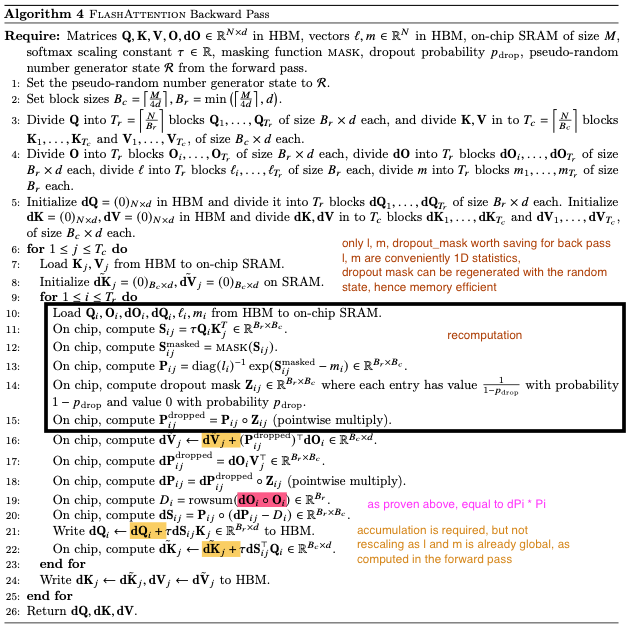
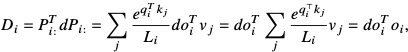

### Initialization

In [12]:
dQ = np.zeros((N, d))
dK = np.zeros((N, d))
dV = np.zeros((N, d))
dQ_blocks = [Q[i:i + Bc] for i in range(0, len(Q), Bc)]
dK_blocks = [Q[i:i + Bc] for i in range(0, len(K), Bc)]
dV_blocks = [Q[i:i + Bc] for i in range(0, len(V), Bc)]


In [ ]:

def inner_iter(i, j, hbm=hbm):
    K_blocks = hbm['K_blocks']
    V_blocks = hbm['V_blocks']
    Q_blocks = hbm['Q_blocks']
    dK_blocks = hbm['dK_blocks']
    dV_blocks = hbm['dV_blocks']
    dQ_blocks = hbm['dQ_blocks']
    dK_block = sram['dK_block']
    dV_block = sram['dV_block']
    dO = hbm['dO']
    O = hbm['O']
    m = hbm['m']
    l = hbm['l']

    with np.printoptions(precision=2, suppress=True):

############################
    # Apply causal mask directly to S
    S_cm = np.where(np.tril(np.ones_like(S), k=0) == 1, S, -np.inf)
    print(f"\tmasked S")
    print(S_cm)

    m = np.max(S_cm, axis=1, keepdims=True)
    S_ = S_cm - m
    P = np.exp(S_)
    print(f"softmax numerator P:")
    print(f"\tP \t\t\t\t<=exp\t\t\t (S - m):")
    print_matop(P, S_, separator='\t\t')

    l = np.sum(np.exp(P), axis=1, keepdims=True)

    # Apply dropout to P
    drop_mask = ((np.random.rand(*P.shape) > p_drop) / (1 - p_drop))
    P_dm = P * drop_mask 
    print(f"P after drop_out:")
    print(f"\tP_dm \t\t\t<=drop_out\t\t\t P \t\t\tby\t\t\t drop_mask:")
    print_matop(P_dm, P, drop_mask, separator='\t\t')

    A = P_dm / l
    print(f"Attention Score A:")
    print(f"\t\tA \t\t\t=\t\t\t\t P_dm \t\t\t/\t sum(exp(S_cm - m))")
    print_matop(A, P_dm, l, separator='\t\t\t')

    O = A @ V
    print(f"output matrix O:")
    print(f"\tO \t=\t\t\t A \t\t\t@\t\t V")
    print_matop(O, A, V)

    # Backward pass
    print("\nBackward Pass Outputs:")    
    print("#" * 50)
    print(f"\tdO obtained from the next layer in backprop")
    print(dO)

    dV = P_dm.T @ dO
    print(f"\tdV \t\t=\t\t P.T \t\t\t@\t\t dO")
    print_matop(dV, P.T, dO)

    dP_dm = dO @ V.T
    print(f"\tdP_dm \t\t\t\t=\t\t dO \t@\t\t\t V.T")
    print_matop(dP_dm, dO, V.T)

    dP = dP_dm * drop_mask

    dS = P * (dP - np.sum(P * dP, axis=1, keepdims=True))
    print(f"\tdS \t\t\t\t=\t\t P \t\t\t*\t (dP - np.sum(P * dP))")
    print_matop(dS, P, np.sum(P * dP, axis=1, keepdims=True))

    dQ = dS @ K * tau
    print(f"\tdQ \t=\t\t\t dS \t\t\t@\t\t K\t*\t tau")
    print_matop(dQ, dS, K, np.array([tau]))

    dK = dS.T @ Q * tau
    print(f"\tdK \t=\t\t\t dS.T \t\t\t@\t\t Q\t*\t tau")
    print_matop(dK, dS.T, Q, np.array([tau]))

############################
        # Forward pass
        print("\nForward Pass Outputs:")
        # Loop over K, V blocks (outer loop)
        Kj = K_blocks[j-1]
        Vj = V_blocks[j-1]
        # Loop over Q blocks (inner loop)
        Qi = Q_blocks[i-1]
        print()
        print('#' * 50)
        print(f"Processing blocks K{j} V{j} Q{i}")
        # print(f"K{j}(Bc, d) \t V{j}(Bc, d) \t Q{i}(Br, d)")
        # print_matop(Kj, Vj, Qi, separator='\t')

        # Compute Sij = Q_i * K_j^T
        Sij = tau * Qi @ Kj.T
        print(f"local self attention dot-product:")
        print(f"\tS{i}{j}(Br, Bc) \t\t=\t\t Q{i}(Br, d) \t@\t K{j}^T (d, Bc)\t\t\t\t*\t tau:")
        print_matop(Sij, Qi, Kj.T, np.array([tau]), separator='\t')

        # Apply causal mask directly to Sij
        Sij = np.where(np.tril(np.ones_like(Sij), k=0) == 1, Sij, -np.inf)
        print(f"masked S{i}{j}")
        print(Sij)

        # Load mi from HBM
        # mij = np.max(Sij, axis=1, keepdims=True)
        Sij_ = Sij - mi
        
        print(f"local row-wise max:")
        print(f"m{i}{j}(Br, 1) \t<=rowmax\t S{i}{j}(Br, Bc):")
        print_matop(mij, Sij, separator='\t\t\t\t')

        # Apply dropout to Pij
        Pij = np.exp(Sij_)
        drop_mask = np.random.rand(*Pij.shape) > p_drop
        Pij_ = Pij * (drop_mask / (1 - p_drop))
        print(f"local drop_out masked P{i}{j}:")
        print(f"P{i}{j}_(Br, Bc) \t<=drop_out\t P{i}{j}(Br, Bc) \t\t<=exp\t (S{i}{j} - m{i}{j}):")
        print_matop(Pij_, Pij, Sij_, separator='\t\t')

        # lij = np.sum(Pij_, axis=1, keepdims=True)
        # print(f"local softmax denominator:")
        # print(f"l{i}{j}(Br, 1) \t<=rowsum\t P{i}{j}_(Br, Bc):")
        # print_matop(lij, Pij_, separator='\t\t\t\t')

        Oi = O[(i-1)*Br:i*Br] # (Br, d)
        mi = m[(i-1)*Br:i*Br] # (Br, 1)
        li = l[(i-1)*Br:i*Br]  # (Br, 1)
        print(f'from HBM read in cumulative Output, Row_max and Softmax_denominator:')
        print(f'O{i} \t\t\t m{i} \t\t l{i}')
        print_matop(Oi, mi, li, separator='\t\t')

        # Update m_i_, l_i_
        mi_ = np.maximum(mi, mij)
        print(f"updated cumulative max:")
        print(f"m{i}_(Br,1) \t=\t max(m{i} \t,\t m{i}{j})")
        print_matop(mi_, mi, mij, separator='\t\t\t')

        past_scaled_l = np.exp(mi - mi_) * li
        local_l = np.exp(mij-mi_) * lij
        li_ = past_scaled_l + local_l
        print(f"updated cumulative softmax denominator:")
        print(f"l{i}_(Br,1) \t=\t exp(m{i}-m{i}_) \t*\t l{i} \t\t+\t exp(m{i}{j}-m{i}_) \t*\t l{i}{j}")
        print_matop(li_, np.exp(mi - mi_), li, np.exp(mij-mi_), lij, separator='\t\t\t')

        # Update O_i
        inv_li_ = np.diag(1.0 / li_.flatten())
        scaled_Oi = np.diag(li.flatten()) @ (np.exp(mi-mi_) * Oi)
        print(f"scaled cumulative Output of previous blocks, i.e. [from Q0 to Q{i-1}] @ K{j}.T @ V{j}")
        print(f"scaled_O{i} \t=\t diag(l{i}) \t@\t [exp(m{i}-m{i}_) \t*\t O{i}] \t=\t diag(l{i}) \t@\t [exp(m{i}-m{i}_)*O{i}]")
        print_matop(scaled_Oi, np.diag(li.flatten()), np.exp(mi-mi_), Oi, np.diag(li.flatten()), np.exp(mi-mi_)*Oi)

        scaled_PV = np.exp(mij - mi_) * Pij @ Vj
        print(f"scaled local P@V of current block")
        print(f"scaled_PV \t=\t exp(m{i}{j}-m{i}_) \t*\t [P{i}{j} \t\t@\t V{j}] \t=\t exp(m{i}{j}-m{i}_) \t*\t PV")
        print_matop(scaled_PV, np.exp(mij - mi_), Pij, Vj, np.exp(mij - mi_), Pij@Vj, separator='\t\t')

        Oi = inv_li_ @ (scaled_Oi + scaled_PV)
        print(f"updated cumulative Output of all blocks, i.e. [from Q0 to Q{i}] @ K{j}.T @ V{j}")
        print(f"O{i}_ (Br,d) \t=\t inv_l{i}_\t@\t (scaled_O{i}\t+\t scaled_PV)")
        print_matop(Oi, inv_li_, scaled_Oi, scaled_PV, separator='\t\t')

        # write out Oi to HBM
        hbm['O'][(i-1)*Br:i*Br] = Oi
        # write out li and mi to HBM
        hbm['l'][(i-1)*Br:i*Br] = li_
        hbm['m'][(i-1)*Br:i*Br] = mi_
        print(f'after saving O{i}, m{i}, l{i} to HBM')
        print(f"O \t\t\t m \t\t l ")
        print_matop(hbm['O'], hbm['m'], hbm['l'], separator='\t\t')

    return hbm

for j in range(1, len(K_blocks)+1, 1):
    # reintialize dK, dQ for each outter iteration
    dK_blocks = np.zeros((Bc, d))
    dQ_blocks = np.zeros((Bc, d))
    for i in range(1, len(Q_blocks)+1, 1):
        hbm = inner_iter(i, j, hbm=hbm)